# Hypothesis

My variable is `Package's Historic Reputation`.
I believe that the most important predictors in the chosen priority of `Package's Historic Reputation` are the following:
  - Age of Responder
  - Development Experience
  - Amt. of Projects Worked On
  
The reason I believe these to be the most important is that they're all indicative of a person's overall experience with software development and the longer someone has been working in software development the more they've seen packages abandoned and deprecated so they should value packages that have a historic reputation of being maintained in the past as that is often indicative of being maintained in the future and will prevent them from having breaking changes in their project by packages being abandoned.

## How measures will be calculated from the data
`Age of Responder` is represented by `PG12Resp` in the csv file that we've been given and in order to use them in my linear regression model, I'll be converting each response to a numerical value as follows:
  - 18 - 24 -> 1
  - 25 - 34 -> 2
  - 35 - 44 -> 3
  - 45 - 54 -> 4
  - 55 - 64 -> 5
  - 65 and over -> 6
  
While this transformation isn't perfect, it values those who are older to be the ones who would pick a historied package.

`Development Experience` is represented by `PG6Resp` in the csv file that we've been given and in order to use them in my linear regression model, I'll be converting each response to a numerical value as follows:
  - Less than 2 years -> 1
  - 2 - 5 years -> 2
  - 6 - 8 years -> 3
  - 9 - 12 years -> 4
  - 13 - 19 years -> 5
  - 20 years or more -> 6
  
Similarly to the `Age of Responder` variable, it isn't perfect but it values those with more experience using packages to be the ones to pick long historied packages.

`Amt. of Projects Worked On` is represented by `PG9Resp` in the csv file that we've been given and in order to use them in my linear regression model, I'll be converting each response to a numerical value as follows:
  - 1 -> 1
  - 2 - 3 -> 2
  - 4 - 6 -> 3
  - 7 - 10 -> 4
  - 11 - 15 -> 5
  - 16 - 25 -> 6
  - More than 25 -> 7
  
Similarly to the other two variables, it values those with more experience working on different projects to be the ones to pick long historied packages.

The reason I've set up the transformations this way is that I think that more experience and a higher age lend the wisdom to pick long historied packages over young volatile ones to those developers.

I'll be putting them into different linear regression models to see if any have any correlation with a `Package's Historic Reputation` being given a higher priority.

I'll also be removing any survey that wasn't completed.

## Set up

In [2]:
# For nicer printing
options(digits=2);

#libraries
library(dplyr);
library(tidyr);
library(ggplot2)

## Read and Clean Data

In [3]:
# Read in the data
data <- read.csv("TechSurvey - Survey.csv",header=T);

#remove other variables
extra_vars <- c("PG5_1RRPQ",
                "PG5_2BNUI",
                "PG5_3HDS",
                "PG5_4VGP",
                "PG5_6SSYOP",
                "PG5_7NDYP",
                "PG5_8CP",
                "PG5_9FRP",
                "PG5_10RPA",
                "PG5_11NSG",
                "PG5_12NWG",
                "PG5_13NFG")

data <- data %>% select(-c(extra_vars))

#convert date to unix second
for (i in c("Start", "End"))
    # grab start and end time
    data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))
for (i in 0:12){
    pg_name = paste(c("PG",i,"Submit"), collapse="")
    data[,pg_name] = as.numeric(as.POSIXct(strptime(data[,pg_name], "%Y-%m-%d %H:%M:%S")))
}

#calculate differences in time    
for (i in 12:0){
    prev_pg_name = paste(c("PG", i-1, "Submit"), collapse="");
    if (i == 0)
        prev_pg_name="Start";
    pg_name = paste(c("PG", i, "Submit"), collapse="");
    data[,pg_name] = data[,pg_name] -data[,prev_pg_name];
}

#remove not completed
data_completed = filter(data, Completed == TRUE)

## Explore and Summarize the data

In [4]:
#now explore variables
summary(data_completed);

     Device    Completed       Start               End               PG0Dis   
        :  0   0    :  0   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  0   FALSE:  0   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :605   TRUE :805   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  :186               Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 44  
 Tablet : 14               3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  0               Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                                                                 NA's   :42   
    PG0Shown      PG0Submit    
 Min.   :   0   Min.   :    2  
 1st Qu.:   0   1st Qu.:    6  
 Median : 114   Median :   10  
 Mean   : 257   Mean   :  335  
 3rd Qu.: 432   3rd Qu.:   15  
 Max.   :1190   Max.   :76226  
 NA's   :42                    
                                       PG1PsnUse  
 For personal work and/or research use      :559  
          

## Analysis of the proposed measures

When looking at `PG6` (`Development Experience`), the submit times are fairly standard, however there is a large outlier in the maximum time to answer that question and it most likely is what caused the median to be so high. As for the repsonses themselves, the data is skewed towards the lower end (2 - 5 years) but I'd say that's typical for the industry. The frequency of responses as the amount of development experience trended downward but even `20 years or more` was selected in over 5% of all responses.

When looking at `PG9` (`Amt. of Projects Worked On`), the submit times are fairly standard, except for the ridiculous maximum time of `20,126` seconds that drove the mean way up. The responses are centered around `4 - 6` projects worked on which makes sense as the development experience of the survey takers was around `2 - 5` years and a new project every 6 - 12 months is normal. None of the responses had low frequencies, even the `More than 25` option had a fair amount of selections.

When looking at `PG12` (`Age of Responder`), the submit times were really quick (moreso than many of the other questions) but that may have to do with the optional nature of the question. It may be worth considering lowering the weight that the age of the survey takers has in my model due to the question being answered too fast to fully take-in what it's asking. As for the responses, the data seems to be centered around `25 - 34` which makes since a lot of the survey responsers are likely to be fresh out of school. There is a very low frequency of 65 and older responses but the problems that come along with old age can make typing and complex problem solving more difficult.

## Interpret  basic summaries

In [5]:
sel = c()
for (i in 1:dim(data_completed)[2]) if (is.numeric(data_completed[,i])) sel = c(sel, i);

cor(data[,sel], method="spearman", use="pairwise.complete.obs"); #OK for any: uses ranks

,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1Submit,PG2Submit,PG3Submit,PG4Dtr0_6,PG4Psv7_8,...,PG5_12Order,PG5_13Order,PG5Submit,PG6Submit,PG7Submit,PG8Submit,PG9Submit,PG10Submit,PG11Submit,PG12Submit
Start,1.0000,0.9952,-0.0417,-0.11507,0.1350,0.1156,0.0791,0.0384,0.01210,0.00371,...,-0.0369,0.0598,0.08512,0.0054,0.0776,0.0441,0.04101,0.047,7.9e-02,0.0746
End,0.9952,1.0000,-0.0415,-0.09879,0.1142,0.1550,0.0791,0.0511,-0.05185,-0.04576,...,-0.0359,0.0661,0.09088,0.0051,0.0759,0.0435,0.04071,0.052,7.9e-02,0.0772
PG0Dis,-0.0417,-0.0415,1.0000,0.87220,0.0153,0.0065,0.0041,0.0567,0.16368,0.02668,...,0.0151,0.0384,0.00601,0.0277,0.0097,0.0354,0.00995,-0.029,-4.5e-02,0.0546
PG0Shown,-0.1151,-0.0988,0.8722,1.00000,0.0360,0.0205,0.0023,0.0497,0.08226,0.00036,...,0.0074,0.0407,-0.00888,0.0401,0.0121,0.0264,0.00056,-0.045,-7.1e-02,0.0436
PG0Submit,0.1350,0.1142,0.0153,0.03596,1.0000,0.1088,0.1037,0.1273,-0.00802,-0.03763,...,-0.0161,-0.0280,0.17671,0.1518,0.1365,0.1258,0.17579,0.225,1.1e-01,0.1096
PG1Submit,0.1156,0.1550,0.0065,0.02047,0.1088,1.0000,0.1452,0.2688,-0.06852,0.05661,...,0.0512,-0.0651,0.24670,0.2414,0.1133,0.1069,0.10895,0.170,7.4e-02,0.1137
PG2Submit,0.0791,0.0791,0.0041,0.00235,0.1037,0.1452,1.0000,0.2045,0.00146,0.00897,...,0.0210,-0.0047,0.21851,0.2696,0.1245,0.1567,0.20127,0.099,1.1e-01,0.1073
PG3Submit,0.0384,0.0511,0.0567,0.04968,0.1273,0.2688,0.2045,1.0000,0.00865,0.04424,...,0.0464,-0.0222,0.26048,0.2706,0.1316,0.1822,0.27450,0.161,1.4e-01,0.1642
PG4Dtr0_6,0.0121,-0.0518,0.1637,0.08226,-0.0080,-0.0685,0.0015,0.0087,1.00000,NA,...,0.1774,-0.1289,-0.05214,-0.1618,0.1560,0.0695,-0.07292,0.044,8.4e-04,-0.0272
PG4Psv7_8,0.0037,-0.0458,0.0267,0.00036,-0.0376,0.0566,0.0090,0.0442,NA,1.00000,...,-0.0008,-0.0218,0.08974,-0.0146,-0.0363,0.0526,0.05977,0.069,-4.9e-02,-0.0217


## Transformation and cleaning statement

Let's clean up the data some more before we look at the correlations again.
First I'll get rid of no responses for each variable I'm looking at and then I'll transform the rest of the responses according the outline I proposed in the "How measures will be calculated from the data" section that is as follows:

`Age of Responder`:
  - 18 - 24 -> 1
  - 25 - 34 -> 2
  - 35 - 44 -> 3
  - 45 - 54 -> 4
  - 55 - 64 -> 5
  - 65 and over -> 6
  
While this transformation isn't perfect, it values those who are older to be the ones who would pick a historied package.

`Development Experience`:
  - Less than 2 years -> 1
  - 2 - 5 years -> 2
  - 6 - 8 years -> 3
  - 9 - 12 years -> 4
  - 13 - 19 years -> 5
  - 20 years or more -> 6
  
Similarly to the `Age of Responder` variable, it isn't perfect but it values those with more experience using packages to be the ones to pick long historied packages.

`Amt. of Projects Worked On`:
  - 1 -> 1
  - 2 - 3 -> 2
  - 4 - 6 -> 3
  - 7 - 10 -> 4
  - 11 - 15 -> 5
  - 16 - 25 -> 6
  - More than 25 -> 7
  
Similarly to the other two variables, it values those with more experience working on different projects to be the ones to pick long historied packages.

In [7]:
# Get rid of no responses
new_data <- filter(data, PG5_5PHR != "")
new_data <- filter(data, PG6Resp != "")
new_data <- filter(data, PG9Resp != "")
new_data <- filter(data, PG12Resp != "")

# Convert PG6Resp to be usable by linear regression model
levels(data$PG6Resp) <- c(levels(data$PG6Resp), 0, 1, 2, 3, 4, 5, 6)
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == ""), '0')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "Less than 2 years"), '1')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "2 - 5 years"), '2')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "6 - 8 years"), '3')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "9 - 12 years"), '4')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "13 - 19 years"), '5')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "20 years or more"), '6')
new_data <- transform(new_data, PG6Resp = as.numeric(as.character(PG6Resp)))

# Convert PG9Resp to be usable by linear regression model
levels(data$PG9Resp) <- c(levels(data$PG9Resp), 0, 1, 2, 3, 4, 5, 6, 7)
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == ""), '0')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "1"), '1')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "2 - 3"), '2')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "4 - 6"), '3')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "7 - 10"), '4')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "11 - 15"), '5')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "16 - 25"), '6')
new_data$PG9Resp <- replace(new_data$PG9Resp, which(new_data$PG9Resp == "More than 25"), '7')
new_data <- transform(new_data, PG9Resp = as.numeric(as.character(PG9Resp)))

# Convert PG12Resp to be usable by linear regression model
levels(data$PG12Resp) <- c(levels(data$PG12Resp), 0, 1, 2, 3, 4, 5, 6)
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == ""), '0')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "18 - 24"), '1')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "25 - 34"), '2')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "35 - 44"), '3')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "45 - 54"), '4')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "55 - 64"), '5')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "65 and over"), '6')
new_data <- transform(new_data, PG12Resp = as.numeric(as.character(PG12Resp)))

#Convert PG5_5PHR to be usable by linear regression model
levels(data$PG5_5PHR) <- c(levels(data$PG5_5PHR), 0, 1, 2, 3, 4, 5)
new_data$PG5_5PHR <- replace(new_data$PG5_5PHR, which(new_data$PG5_5PHR == ""), '0')
new_data$PG5_5PHR <- replace(new_data$PG5_5PHR, which(new_data$PG5_5PHR == "Not a Priority"), '1')
new_data$PG5_5PHR <- replace(new_data$PG5_5PHR, which(new_data$PG5_5PHR == "Low Priority"), '2')
new_data$PG5_5PHR <- replace(new_data$PG5_5PHR, which(new_data$PG5_5PHR == "Medium Priority"), '3')
new_data$PG5_5PHR <- replace(new_data$PG5_5PHR, which(new_data$PG5_5PHR == "High Priority"), '4')
new_data$PG5_5PHR <- replace(new_data$PG5_5PHR, which(new_data$PG5_5PHR == "Essential"), '5')
new_data <- transform(new_data, PG5_5PHR = as.numeric(as.character(PG5_5PHR)))

print(summary(new_data$PG6Resp))
print(summary(new_data$PG9Resp))
print(summary(new_data$PG12Resp))
summary(new_data$PG5_5PHR)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     2.0     2.0     2.5     3.0     6.0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     2.0     3.0     3.3     4.0     7.0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     2.0     3.0     2.7     3.0     6.0 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     3.0     2.5     4.0     5.0 

## Top Correlations

Now, just show the top correlations

In [8]:
# Define a function
hiCor <- function(data, level){
  results <- cor(data, method="spearman", use="pairwise.complete.obs");
  # set NA to 0
  results[is.na(results)] <- 0
  
  # convert negative correlations to positive
  pos_results <- results;
  pos_results[results < 0] <- -results[results < 0];
    
  # set diagonal to 0
  for (i in 1:dim(data)[2]){
    pos_results[i,i] <- 0;
  }
  
  sel <- apply(pos_results, 1, max) > level;
  results[sel,sel];
}
high_corr <- hiCor(data_completed[, sel],.7)

# print high correlations
high_corr

,Start,End,PG0Dis,PG0Shown,PG4Dtr0_6,PG4Psv7_8,PG4Prm9_10,PG4AllResp
Start,1.000,0.995,-0.046,-0.0977,-0.014,-0.0481,-0.027,-0.011
End,0.995,1.000,-0.042,-0.0988,-0.052,-0.0458,-0.027,-0.016
PG0Dis,-0.046,-0.042,1.000,0.8693,0.194,0.0296,-0.017,0.012
PG0Shown,-0.098,-0.099,0.869,1.0000,0.151,-0.0085,0.025,-0.014
PG4Dtr0_6,-0.014,-0.052,0.194,0.1508,1.000,0.0000,0.000,1.000
PG4Psv7_8,-0.048,-0.046,0.030,-0.0085,0.000,1.0000,0.000,1.000
PG4Prm9_10,-0.027,-0.027,-0.017,0.0249,0.000,0.0000,1.000,1.000
PG4AllResp,-0.011,-0.016,0.012,-0.0142,1.000,1.0000,1.000,1.000


## Correlation Analysis

From the table above, it would seem that none of the correlations between any of the other variables and the priorities chosen for `Package's Historic Reputation` are more correlated than 0.7. Thus, none of them should need to be dropped.

As for general correlations from the "Interpret basic summaries" section, none of the submit times for the variables I've picked are very correlated with the order of my response variable. That may not be good for my hypothesis but it also might just be that submit time doesn't matter much when it comes to the priority of my response variable.

`0.0498` between my response variable and submitting page 6,
`-0.02976` between my response variable and submitting page 9,
`0.0085` between my response variable and submitting page 12

## Fit the statistical model

As I've outlined "How measures will be calculated from the data" I will be using a linear regression model to see if there is any direct correlation between the importantance of a Package's Historic Reputation and the three variables I've picked. For the linear regression model I'll be using R's built in lm function and then plotting the model and other data using ggplot using ggplot2.


Call:
lm(formula = PG5_5PHR ~ PG6Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.600 -2.517  0.466  1.466  2.499 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.5007     0.1293   19.34   <2e-16 ***
PG6Resp       0.0165     0.0456    0.36     0.72    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.8 on 761 degrees of freedom
Multiple R-squared:  0.000172,	Adjusted R-squared:  -0.00114 
F-statistic: 0.131 on 1 and 761 DF,  p-value: 0.718


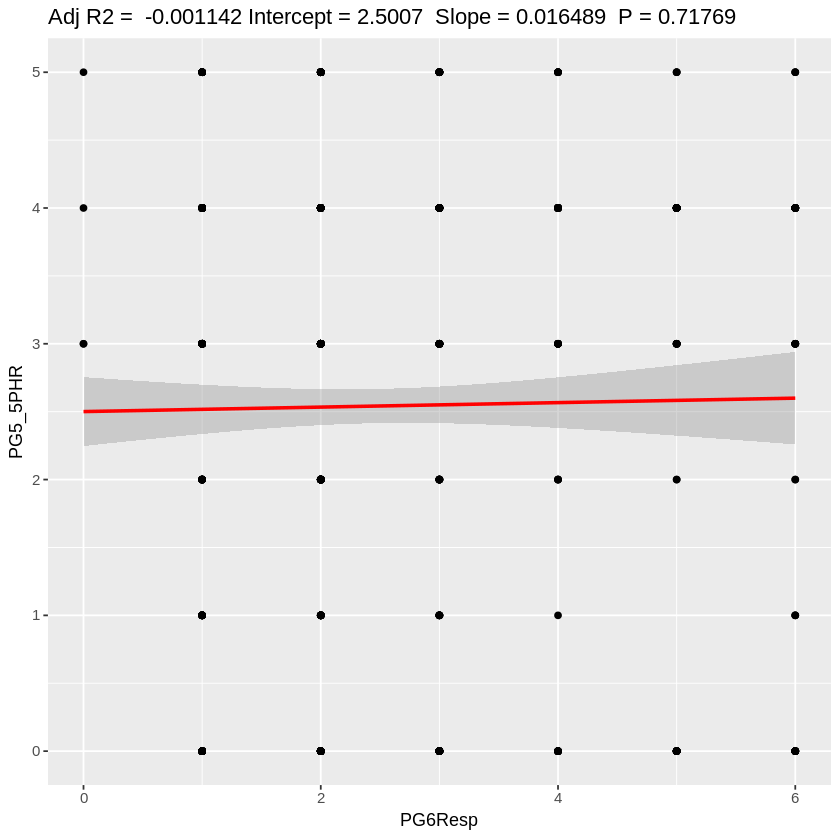

In [12]:
model_pg6 <- lm(PG5_5PHR ~ PG6Resp, data = new_data)
summary(model_pg6)

ggplot(new_data, aes(x = PG6Resp, y = PG5_5PHR)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adj R2 = ",signif(summary(model_pg6)$adj.r.squared, 5),
                     "Intercept =",signif(model_pg6$coef[[1]], 5),
                     " Slope =",signif(model_pg6$coef[[2]], 5),
                     " P =",signif(summary(model_pg6)$coef[2,4], 5)))


Call:
lm(formula = PG5_5PHR ~ PG9Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
 -2.69  -2.45   0.51   1.47   2.59 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.410      0.131   18.37   <2e-16 ***
PG9Resp        0.040      0.035    1.14     0.25    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.8 on 761 degrees of freedom
Multiple R-squared:  0.00172,	Adjusted R-squared:  0.000404 
F-statistic: 1.31 on 1 and 761 DF,  p-value: 0.253


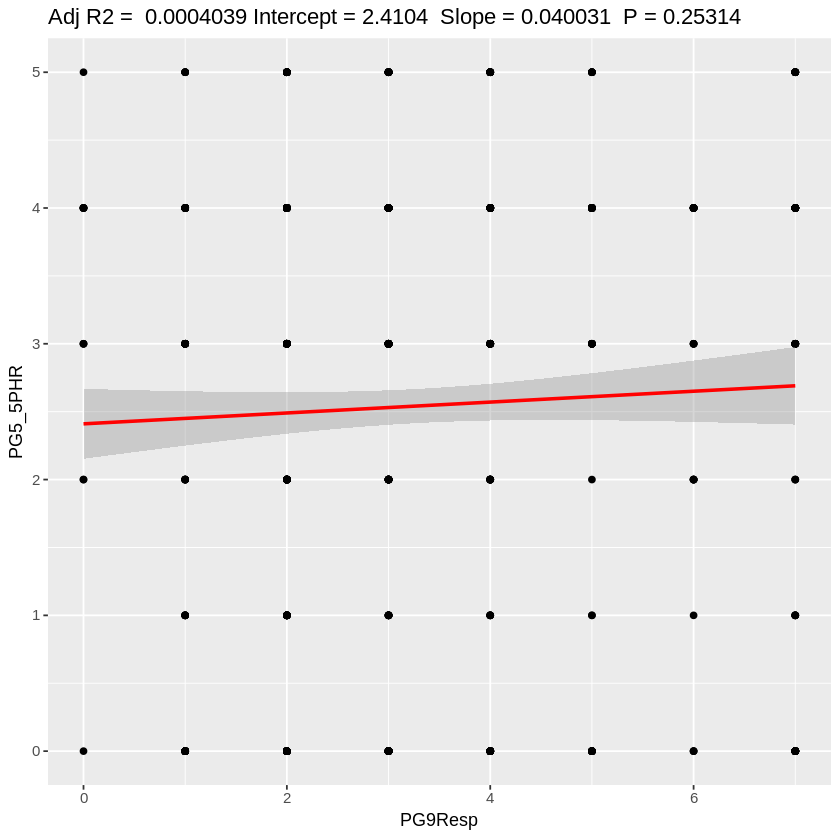

In [13]:
model_pg9 <- lm(PG5_5PHR ~ PG9Resp, data = new_data)
summary(model_pg9)

ggplot(new_data, aes(x = PG9Resp, y = PG5_5PHR)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adj R2 = ",signif(summary(model_pg9)$adj.r.squared, 5),
                     "Intercept =",signif(model_pg9$coef[[1]], 5),
                     " Slope =",signif(model_pg9$coef[[2]], 5),
                     " P =",signif(summary(model_pg9)$coef[2,4], 5)))


Call:
lm(formula = PG5_5PHR ~ PG12Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.557 -2.521  0.461  1.461  2.479 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.56545    0.19080   13.45   <2e-16 ***
PG12Resp    -0.00892    0.06630   -0.13     0.89    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.8 on 761 degrees of freedom
Multiple R-squared:  2.38e-05,	Adjusted R-squared:  -0.00129 
F-statistic: 0.0181 on 1 and 761 DF,  p-value: 0.893


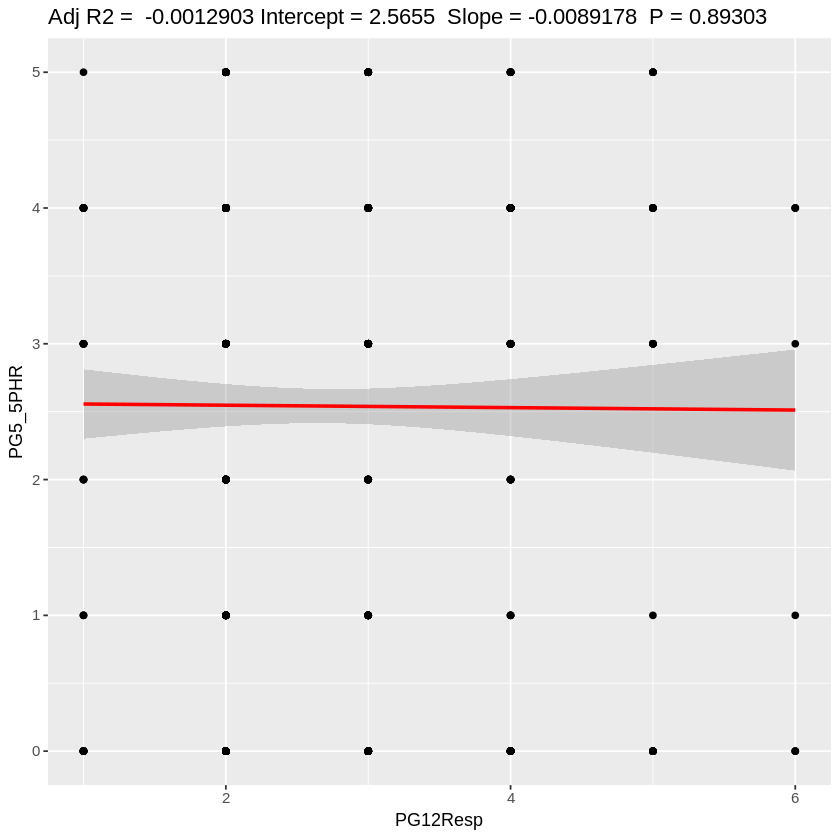

In [14]:
model_pg12 <- lm(PG5_5PHR ~ PG12Resp, data = new_data)
summary(model_pg12)

ggplot(new_data, aes(x = PG12Resp, y = PG5_5PHR)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adj R2 = ",signif(summary(model_pg12)$adj.r.squared, 5),
                     "Intercept =",signif(model_pg12$coef[[1]], 5),
                     " Slope =",signif(model_pg12$coef[[2]], 5),
                     " P =",signif(summary(model_pg12)$coef[2,4], 5)))


Call:
lm(formula = PG5_5PHR ~ PG6Resp + PG9Resp + PG12Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.748 -2.418  0.486  1.461  2.583 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.4909     0.2018   12.34   <2e-16 ***
PG6Resp      -0.0069     0.0553   -0.12     0.90    
PG9Resp       0.0482     0.0412    1.17     0.24    
PG12Resp     -0.0333     0.0725   -0.46     0.65    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.8 on 759 degrees of freedom
Multiple R-squared:  0.00208,	Adjusted R-squared:  -0.00186 
F-statistic: 0.528 on 3 and 759 DF,  p-value: 0.663


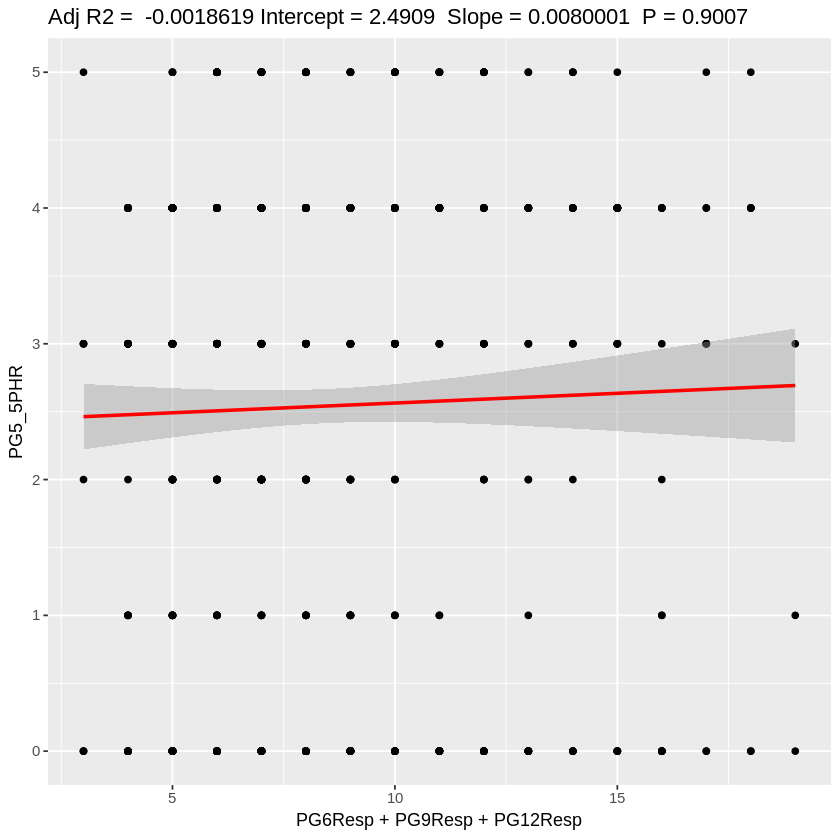

In [15]:
model_all <- lm(PG5_5PHR ~ PG6Resp + PG9Resp + PG12Resp, data = new_data)
summary(model_all)

ggplot(new_data, aes(x = PG6Resp + PG9Resp + PG12Resp, y = PG5_5PHR)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adj R2 = ",signif(summary(model_all)$adj.r.squared, 5),
                     "Intercept =",signif(model_all$coef[[1]], 5),
                     " Slope =",signif(model_all$coef[[2]] + model_all$coef[[3]] + model_all$coef[[4]], 5),
                     " P =",signif(summary(model_all)$coef[2,4], 5)))

## Interpretation of coefficients

For model 1:
  - `r^2` was extremely low
  - the slope is positive so there is a positive effect but there is no statistical signifigance in it
  
For model 2:
  - `r^2` was extremely low
  - the slope is positive so there is a positive effect but there is no statistical signifigance in it

For model 3:
  - `r^2` was extremely low
  - the slope is negative so there is a negative effect but there is no statistical signifigance in it
  
For model 4:
  - `r^2` was extremely low
  - the slope is positive so there is a positive effect but there is no statistical signifigance in it
 
While none of the effects that each variable has on valuing a `Package's Historic Reputation` are significantly significant, it does seem that there is a positive effect between working on more projects and having more development experience when it comes to valuing a `Package's Historic Reputation`.

Overall, due to none of the models I tried having any statistical significance, my hypothesis was wrong.

It has given me some insight into what potential factors I should focus on for the next experiment.

## Extra Credit

For starters, requiring all of the questions to have answers would be helpful. There were many PGXResp variables that had null or empty rows.

Based off of my analysis, it would also be helpful if the optional questions were required instead so that I could potentially have more responses for the upper limits of my variables (65+, 20 yrs or more, and 25+ projects).

Also require all factors to be put in one of the 5 priority bins.

More specific questions on why they chose a specific priority.